# Preface
This notebook uses several packages from CRAN, as well as [Bioconductor](https://bioconductor.org). For a full list of attached packages see the session info in the Appendix at the end of this notebook. Several options have been adjusted to improve appearance of plots.

In [2]:
## Load necessary packages
suppressMessages({
    
    library("xcms")
    library("CAMERA")
    library("RColorBrewer")
    library("SummarizedExperiment")
    library("tidyverse")
    library("gplots")
    library("ggrepel")
    library("Rtsne")
    library("caret")
    library("MASS")
    
})

## Set session-specific options
options(repr.plot.width = 12, # Adjust plot width for publication purposes
        repr.plot.height = 8, # Adjust plot height for publication purposes,
        scipen = -1) # Adjust scientific notation of numbers to improve readability of plots

## List mzXML files
mzXMLs <- list.files(path = getwd(), recursive = TRUE, 
                     full.names = TRUE, pattern = ".mzXML")

# Quality Control of Raw Data
The following injection order during analysis correspond to the order files are read using list.files. In case several batches were analysed, as vector containing an integer for each batch assignment of each sample must be given.

In [3]:
## List mzXML files
mzXMLs <- list.files(path = "BEH_pos", recursive = TRUE, 
                     full.names = TRUE, pattern = ".mzXML")

## Aggregate meta data
sample.name <- sub(basename(mzXMLs), pattern = ".mzXML", 
                   replacement = "", fixed = TRUE)
sample.group <- c(rep("Control", 5), rep("alpha-PCYP", 5), 
                  rep("QC", 7))
sample.order <- c(8,10,15,7,13,16,12,9,14,6,1,2,3,4,5,11,17)
sample.batch <- NA
meta <- data.frame(sample_name = sample.name, 
                   sample_group = sample.group, 
                   sample_order = sample.order, 
                   sample_batch = sample.batch, 
                   stringsAsFactors = FALSE)

## Read raw data from disk
raw <- readMSData(files = mzXMLs[order(sample.order)], 
                  pdata = new("AnnotatedDataFrame", 
                              meta[order(sample.order),]), 
                  mode = "onDisk")
## Remove column equilibration and washing phases
raw <- filterRt(raw, c(60,600))

class(raw)

print(raw)

[1] "OnDiskMSnExp"
attr(,"package")
[1] "MSnbase"

MSn experiment data ("OnDiskMSnExp")
Object size in memory: 4.99 Mb
- - - Spectra data - - -
 MS level(s): 1 
 Number of spectra: 17691 
 MSn retention times: 1:0 - 9:60 minutes
- - - Processing information - - -
Data loaded [Fri Oct 22 11:35:41 2021] 
Filter: select retention time [60-600] and MS level(s), 1 [Fri Oct 22 11:35:41 2021] 
 MSnbase version: 2.14.2 
- - - Meta data  - - -
phenoData
  rowNames: 11 12 ... 17 (17 total)
  varLabels: sample_name sample_group sample_order sample_batch
  varMetadata: labelDescription
Loaded from:
  [1] pQC_1.mzXML...  [17] pQC_7.mzXML
  Use 'fileNames(.)' to see all files.
protocolData: none
featureData
  featureNames: F01.S0117 F01.S0118 ... F17.S1157 (17691 total)
  fvarLabels: fileIdx spIdx ... spectrum (35 total)
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'


# Inspection of Parent Compound and Internal Standard
This experiment used deuterated tryptophan as an internal standard to normalise variability introduced by injection of the samples into the mass spectrometer. Quality control in at this stage includes ensuring that both the internal standard, as well as the parent compound, have been detected properly and the within group variability is acceptable.

In [4]:
## Define colours for experimental groups
group.colours <- paste0(brewer.pal(3, "Set1")[1:3])
names(group.colours) <- c("Control", "alpha-PCYP", "QC")

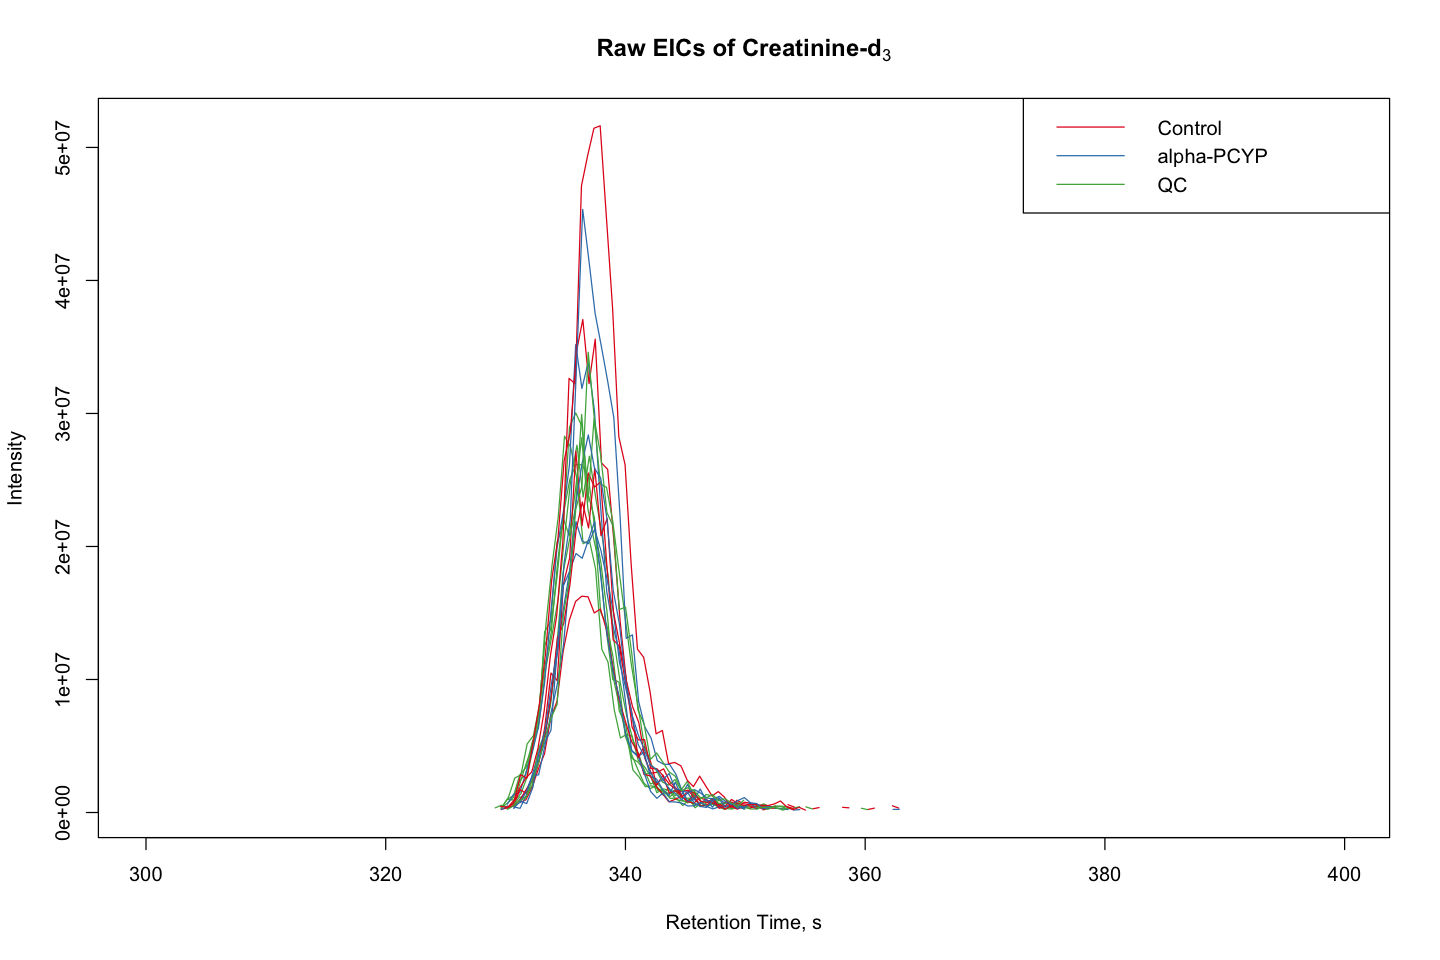

In [6]:
## Plot raw EICs of creatinine-d3 (m/z 117.0856, 25 s)
cread3.raw <- chromatogram(raw, mz = c(117.0841, 117.0871), rt = c(300, 400))

plot(cread3.raw, col = group.colours[cread3.raw$sample_group], 
     main = bquote(bold("Raw EICs of Creatinine-d"[3])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

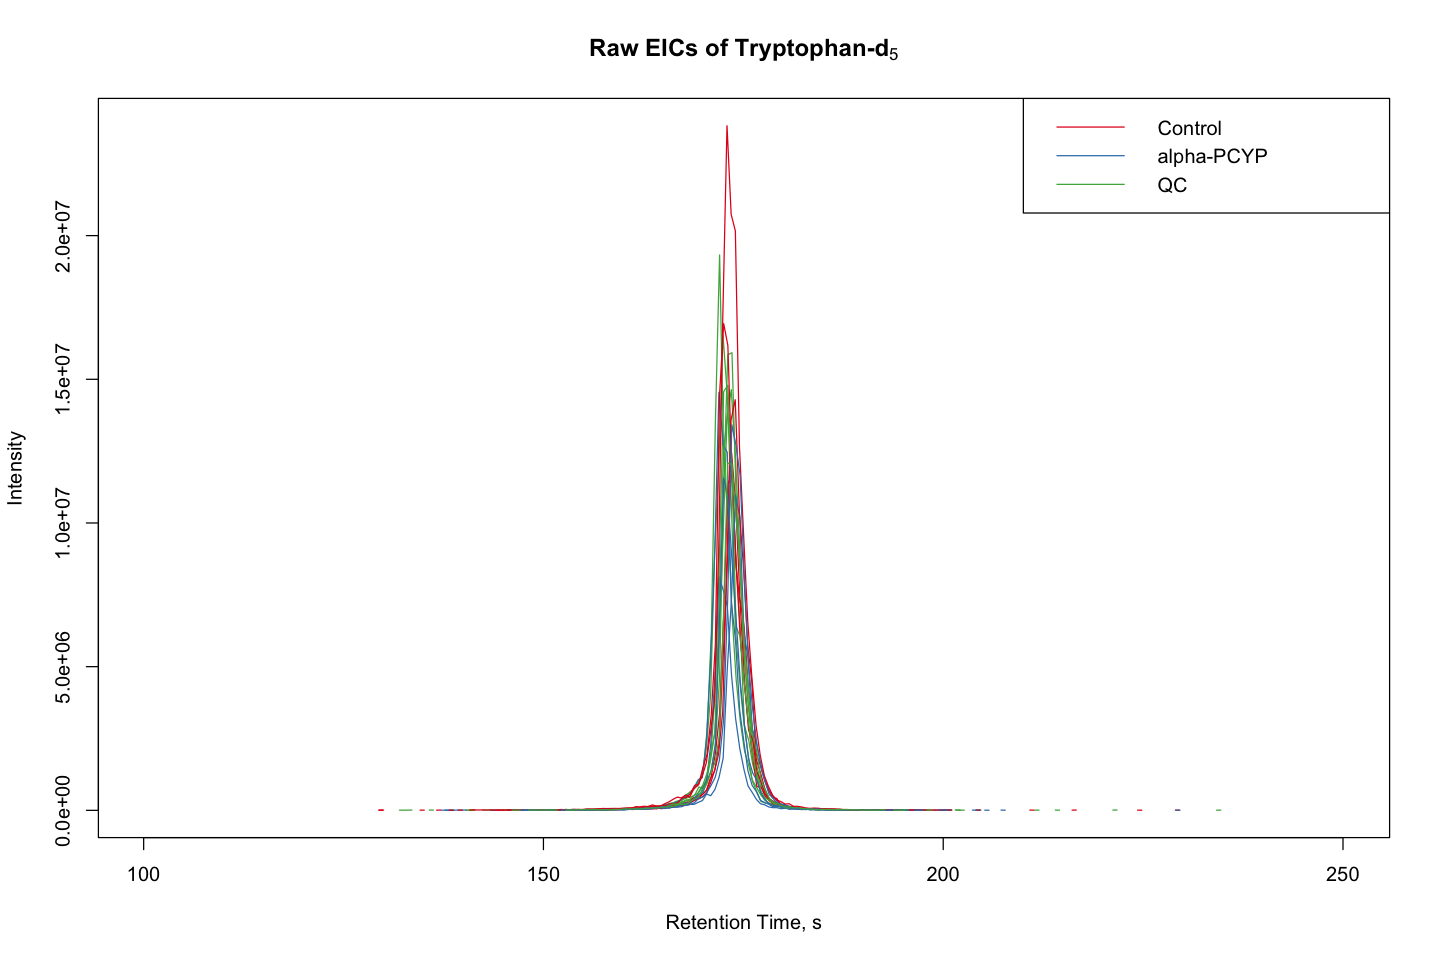

In [7]:
## Define colours for experimental groups
group.colours <- paste0(brewer.pal(3, "Set1")[1:3])
names(group.colours) <- c("Control", "alpha-PCYP", "QC")


## Plot tryptophan-d5 before processing (m/z 210.1291, 168 s)
trpd5.raw <- chromatogram(raw, mz = c(210.1281, 210.1296), rt = c(100, 250))

plot(trpd5.raw, col = group.colours[trpd5.raw$sample_group], 
     main = bquote(bold("Raw EICs of Tryptophan-d"[5])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

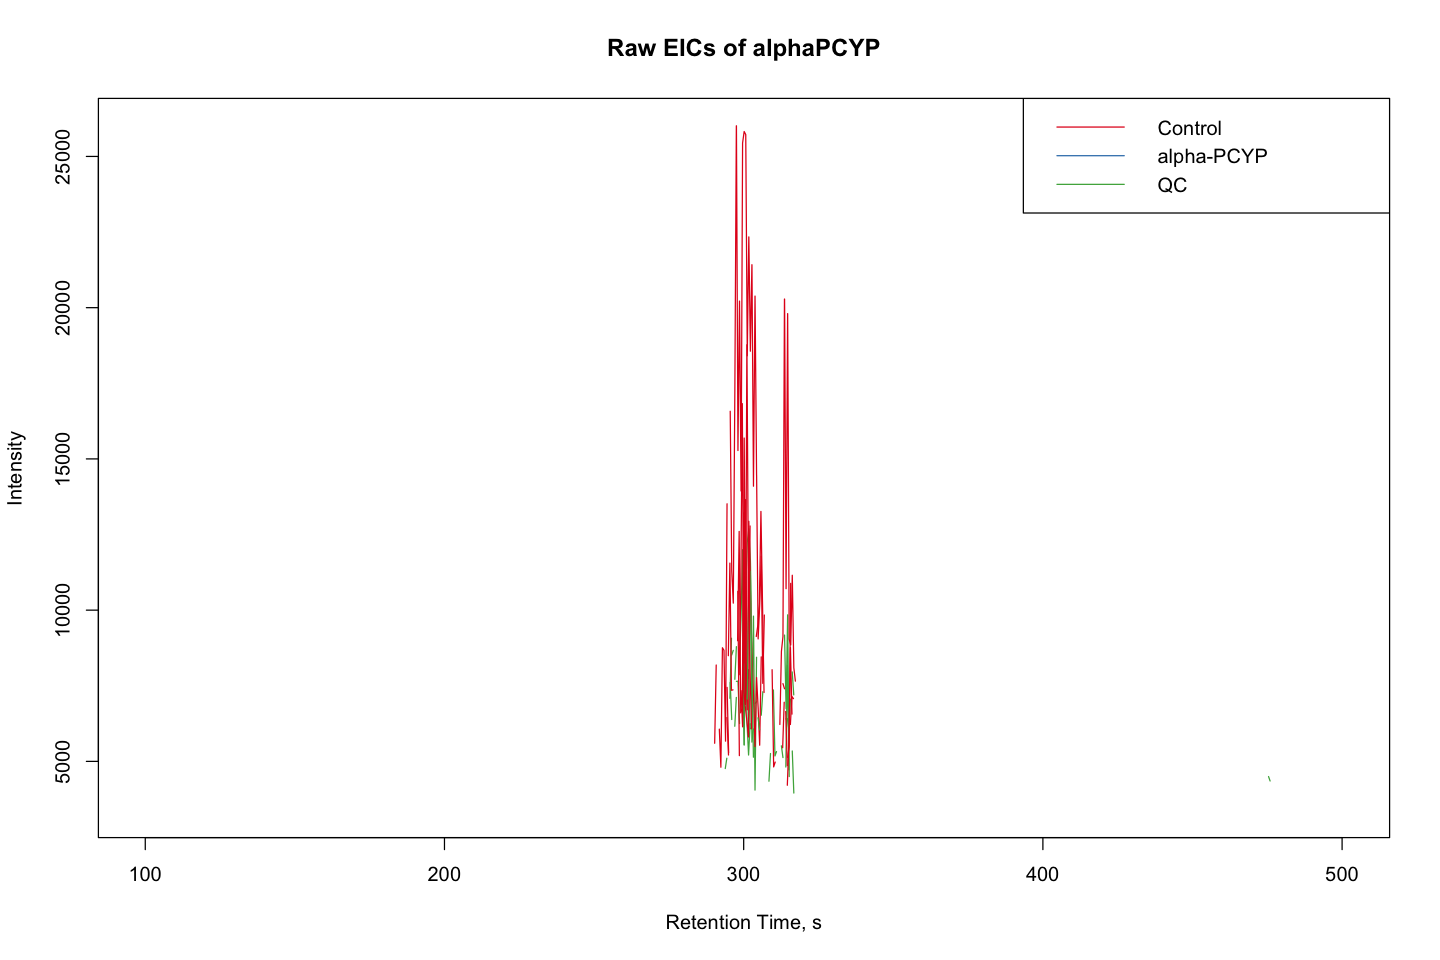

In [8]:
## Plot raw EICs of alpha-PCYP (m/z 272.2008, 25 s)
alphaPCYP.raw <- chromatogram(raw, mz = c(272.2000, 272.2015), rt = c(100, 500))

plot(alphaPCYP.raw, col = group.colours[alphaPCYP.raw$sample_group], 
     main = bquote(bold("Raw EICs of alphaPCYP")), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

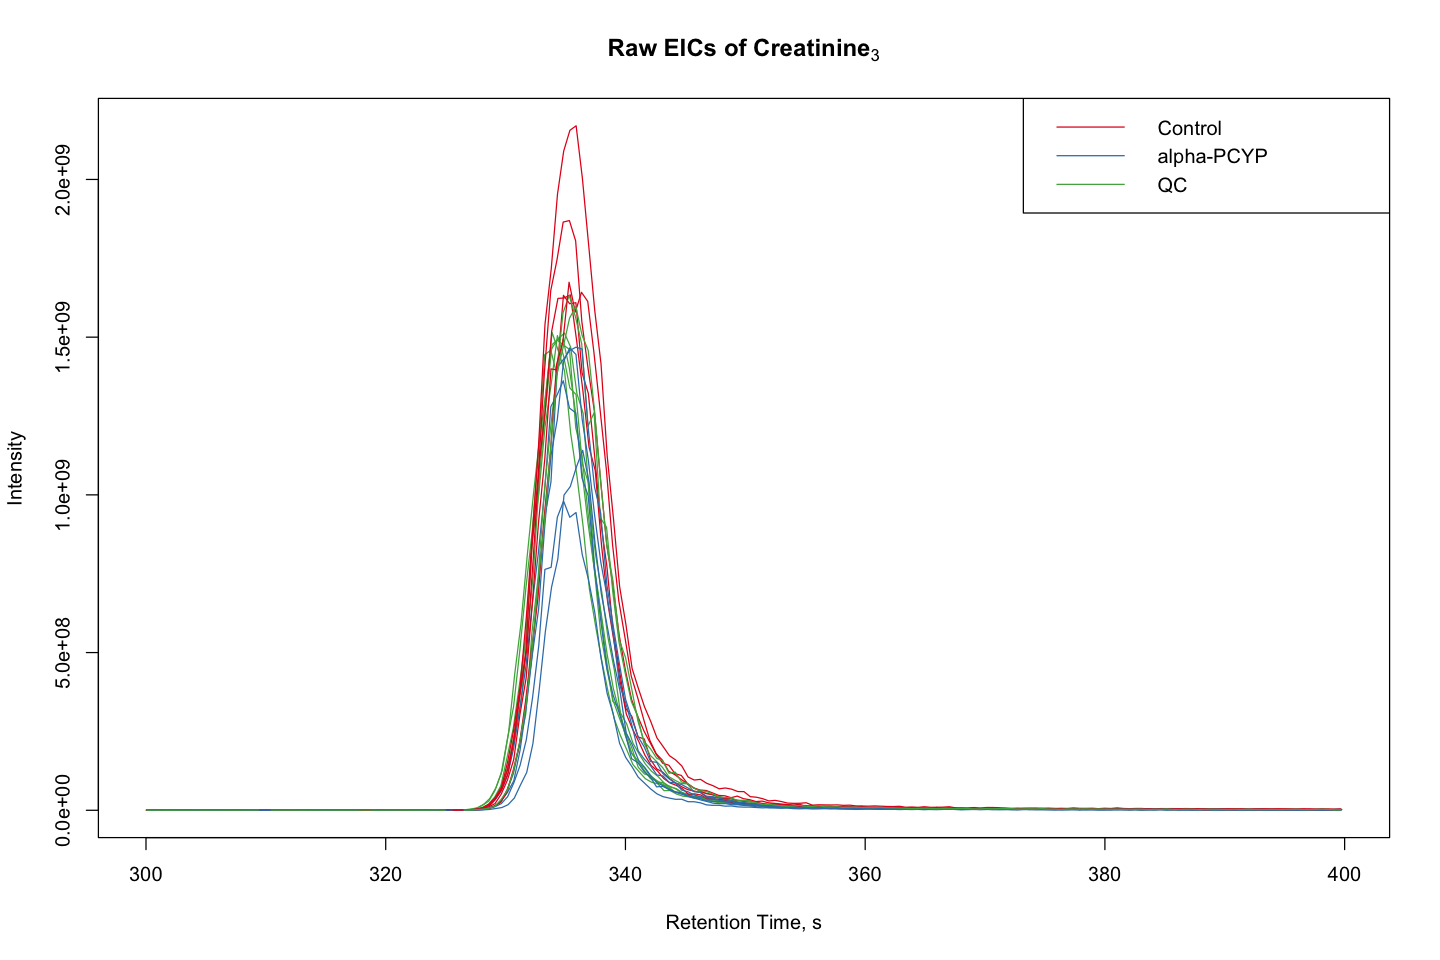

In [12]:
## Plot raw EICs of creatinine (m/z 114.0665, 25 s)
crea.raw <- chromatogram(raw, mz = c(114.0645, 114.0685), rt = c(300, 400))

plot(crea.raw, col = group.colours[crea.raw$sample_group], 
     main = bquote(bold("Raw EICs of Creatinine"[3])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Inspect Total Ion Currents of Sample Files

Total ion currents (TICs) need to be inspected in order to ensure that chromatography and mass spectrometry have been performing properly. Quality control includes the inspection of retention time drifts within TICS and evaluation of the baselines.

In [9]:
## Get total ion chromatograms
tics <- chromatogram(raw, aggregationFun = "sum")

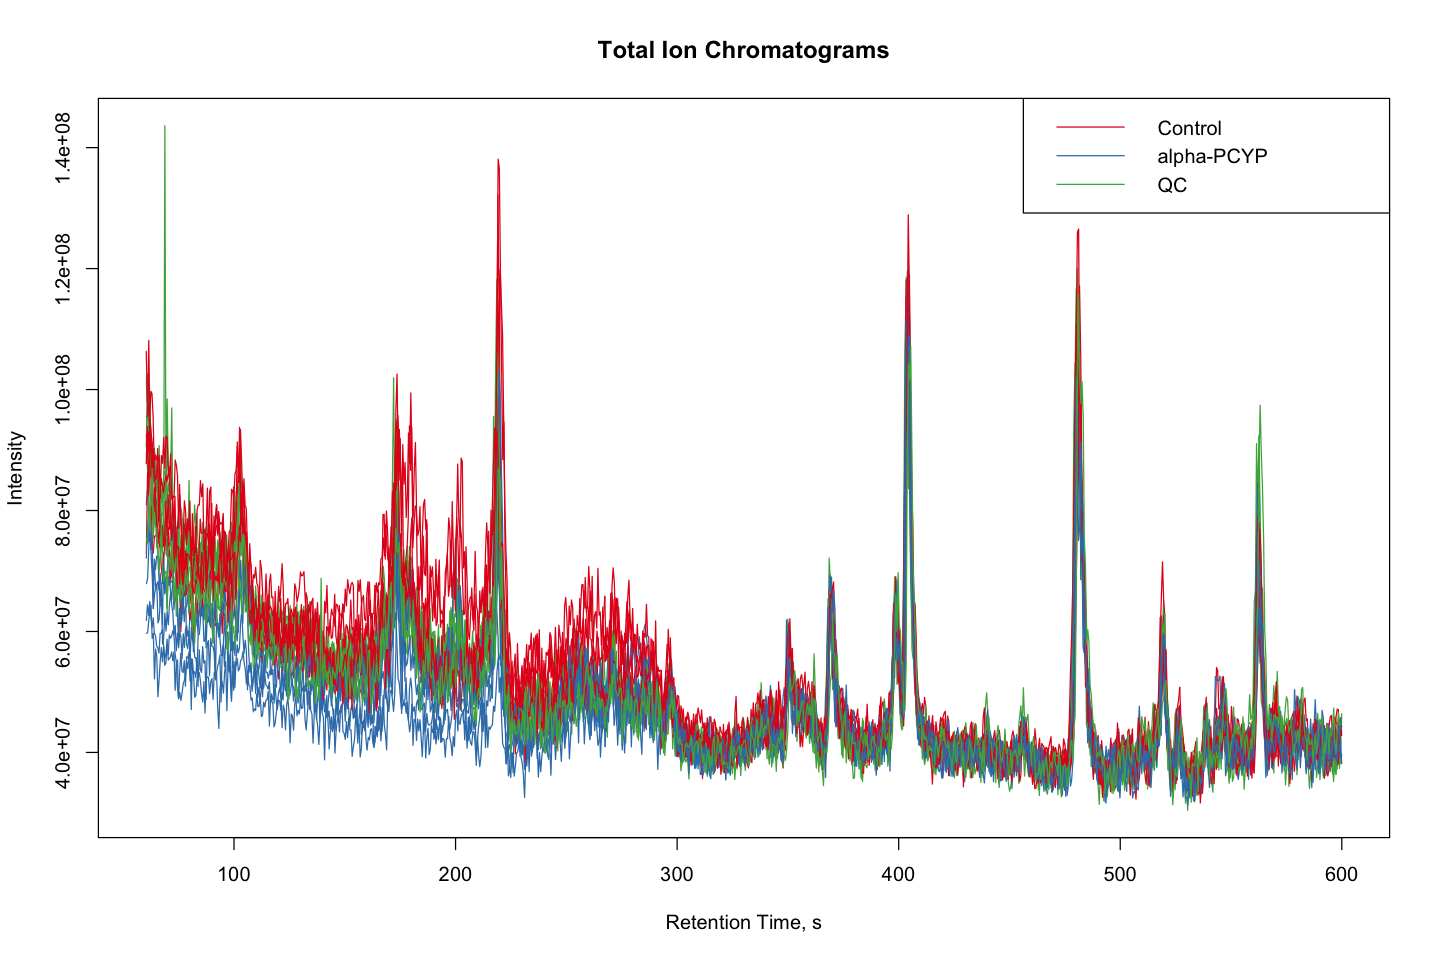

In [10]:
## Plot every total ion chromatogram of the data set
plot(tics, col = group.colours[raw$sample_group], 
     main = "Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

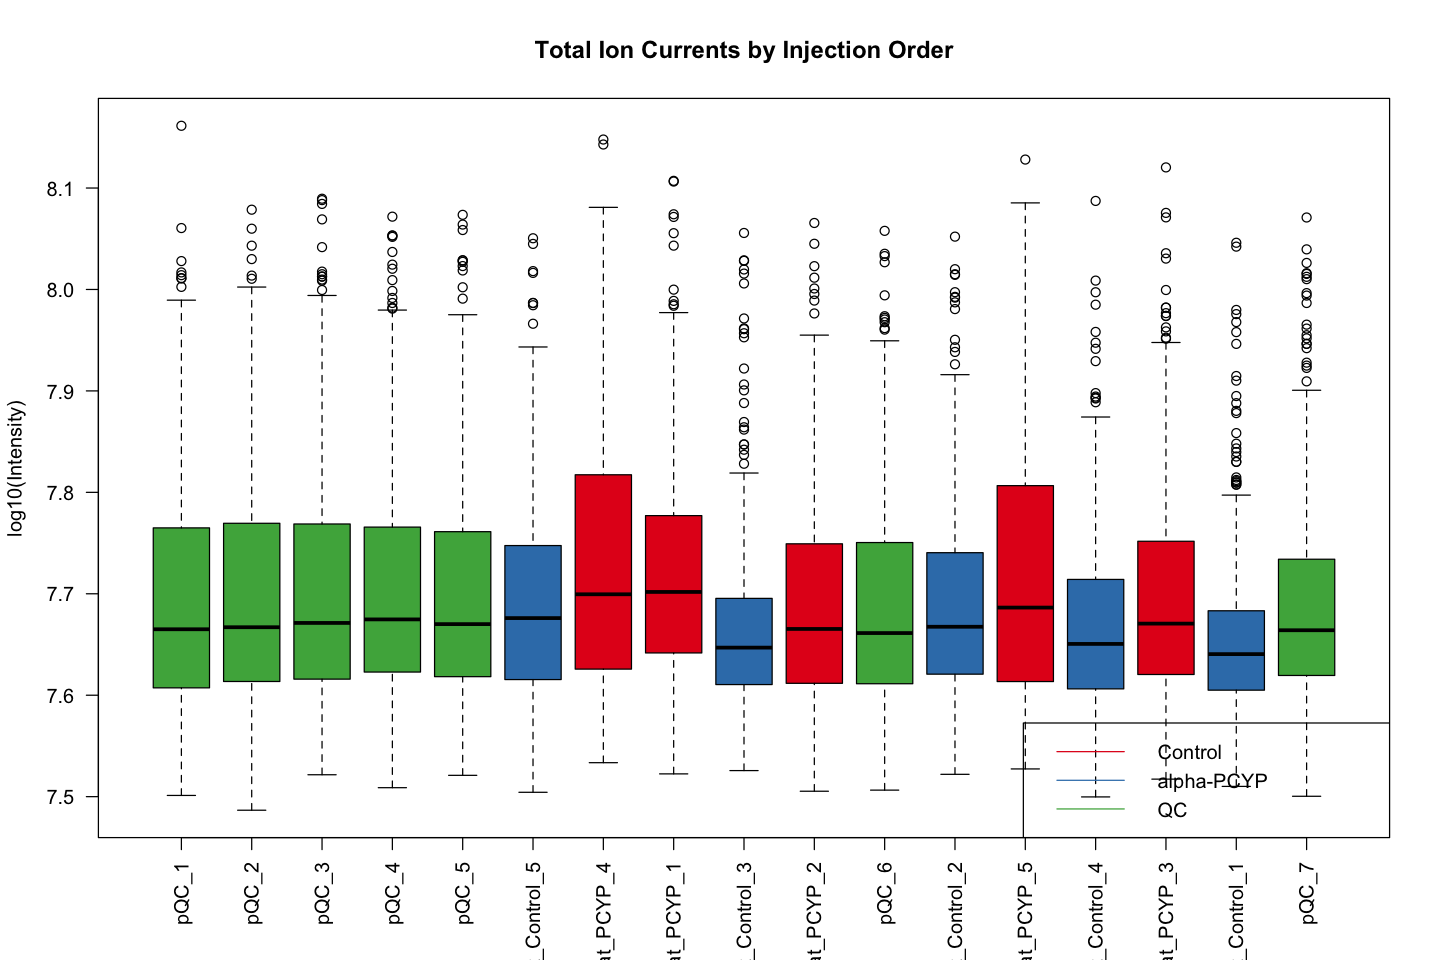

In [11]:
# Inspect boxplots of TICs by injection order
tics.summary <- split(tic(raw), f = fromFile(raw))

boxplot(sapply(tics.summary, log10), names = raw$sample_name, 
        col = group.colours[raw$sample_group], ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Injection Order", las = 2)
legend("bottomright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Preprocessing of Raw Sample Files

# Peak Picking

Parameter used in this section were obtained using the one-by-one optimization performed by centWaveOpt. This approach was published at DOI: 10.1002/dta.2552 by Manier et al.

In [12]:
cwp <- CentWaveParam(peakwidth = c(7.8, 21), ppm = 2.4, snthresh = 12, 
                     mzdiff = -0.098,  prefilter = c(6, 100))

suppressMessages(
    
    set <- findChromPeaks(raw, param = cwp)
    
    )

In [13]:
## Define sample colours
sample.colours <- paste0(brewer.pal(3, "Set1")[1:3], "60")
names(sample.colours) <- c("Control", "alpha-PCYP", "QC")
sample.colours <- sample.colours[raw$sample_group]

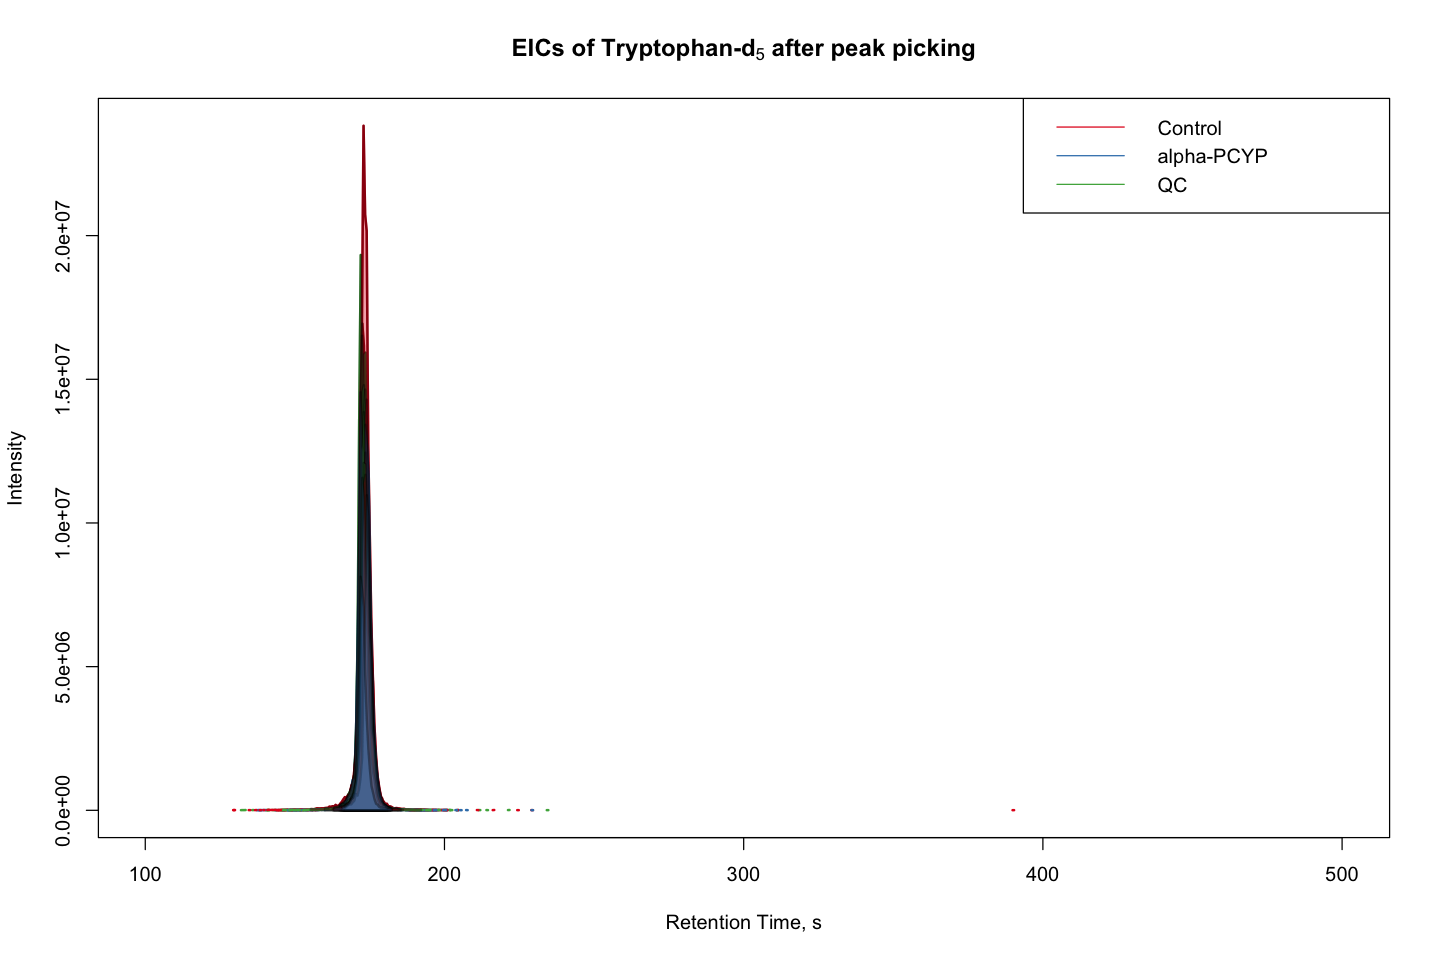

In [14]:
## Plot Tryptophan-d5 after peak picking (m/z 210.1291, 168 s)
trpd5.picked <- chromatogram(set, mz = c(210.1281, 210.1301), rt = c(100, 500)) 

plot(trpd5.picked, col = group.colours[trpd5.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(trpd5.picked)[, "sample"]],
     main = bquote(bold("EICs of Tryptophan-d"[5]*" after peak picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

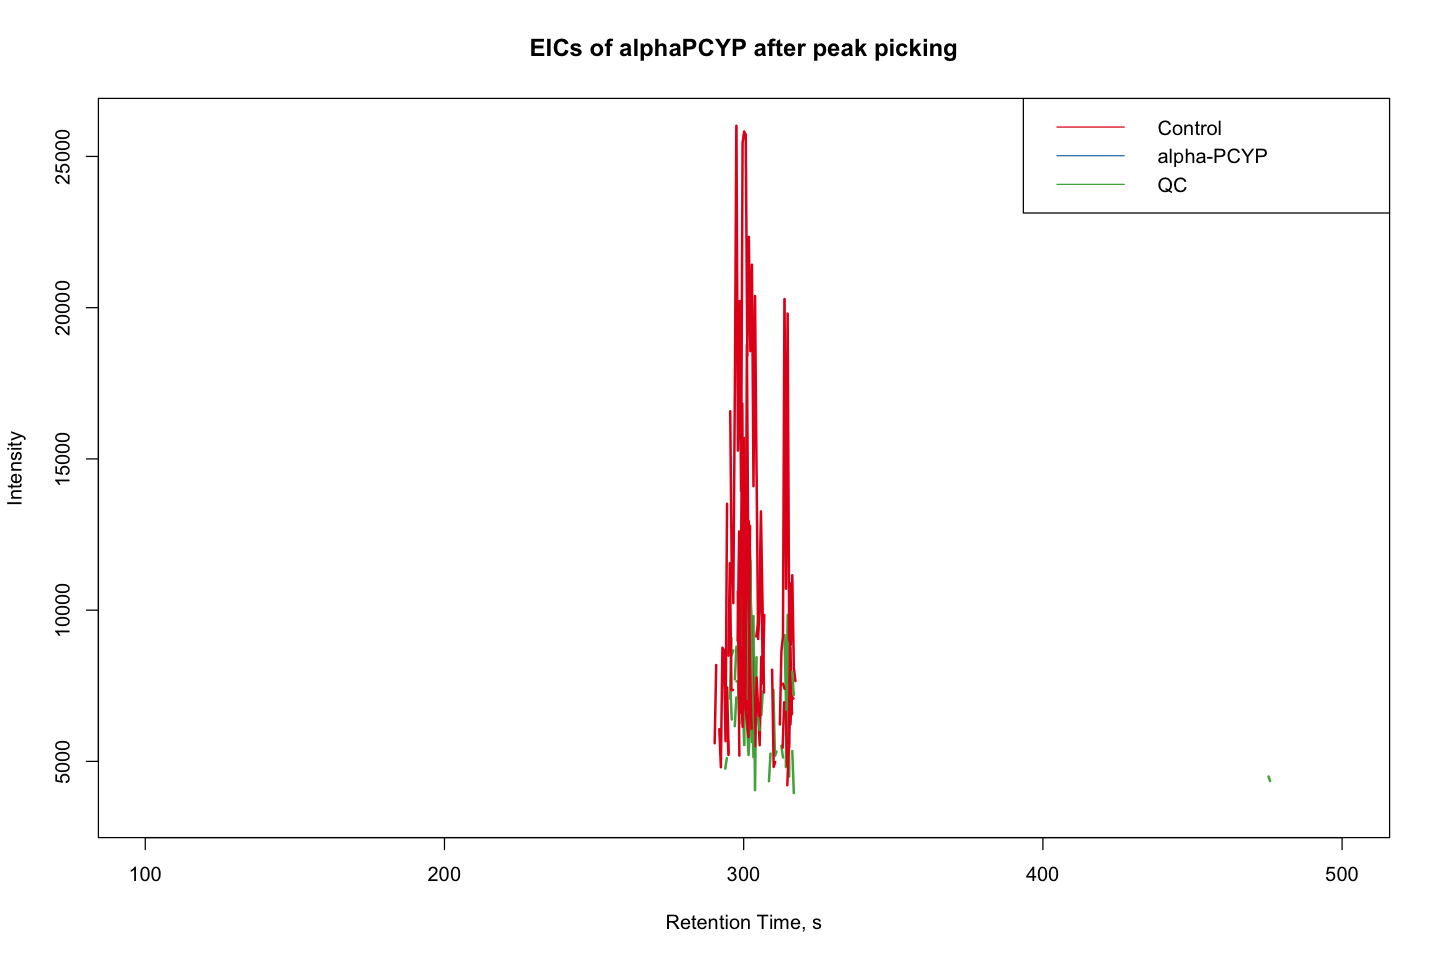

In [16]:
## Plot alpha-PCYP after peak picking (m/z 272.2008, 314 s)
alphaPCYP.picked <- chromatogram(set, mz = c(272.2000, 272.2015), rt = c(100, 500)) 

plot(alphaPCYP.picked, col = group.colours[alphaPCYP.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(alphaPCYP.picked)[, "sample"]],
     main = bquote(bold("EICs of alphaPCYP"*" after peak picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Retention Time Correction

In [17]:
suppressMessages({
    
    set <- adjustRtime(set, param = ObiwarpParam(binSize = 0.6))
    set <- dropAdjustedRtime(set)

    pdp <- PeakDensityParam(sampleGroups = set$sample_group, bw = 1)
    set <- groupChromPeaks(set, param = pdp)

    ## Define subset alignment options and perform the alignment
    pgp <- PeakGroupsParam(minFraction = 0.8, 
                           subset = which(set$sample_group == "QC"),
                           subsetAdjust = "average", span = 0.2)
    set <- adjustRtime(set, param = pgp)
    
})

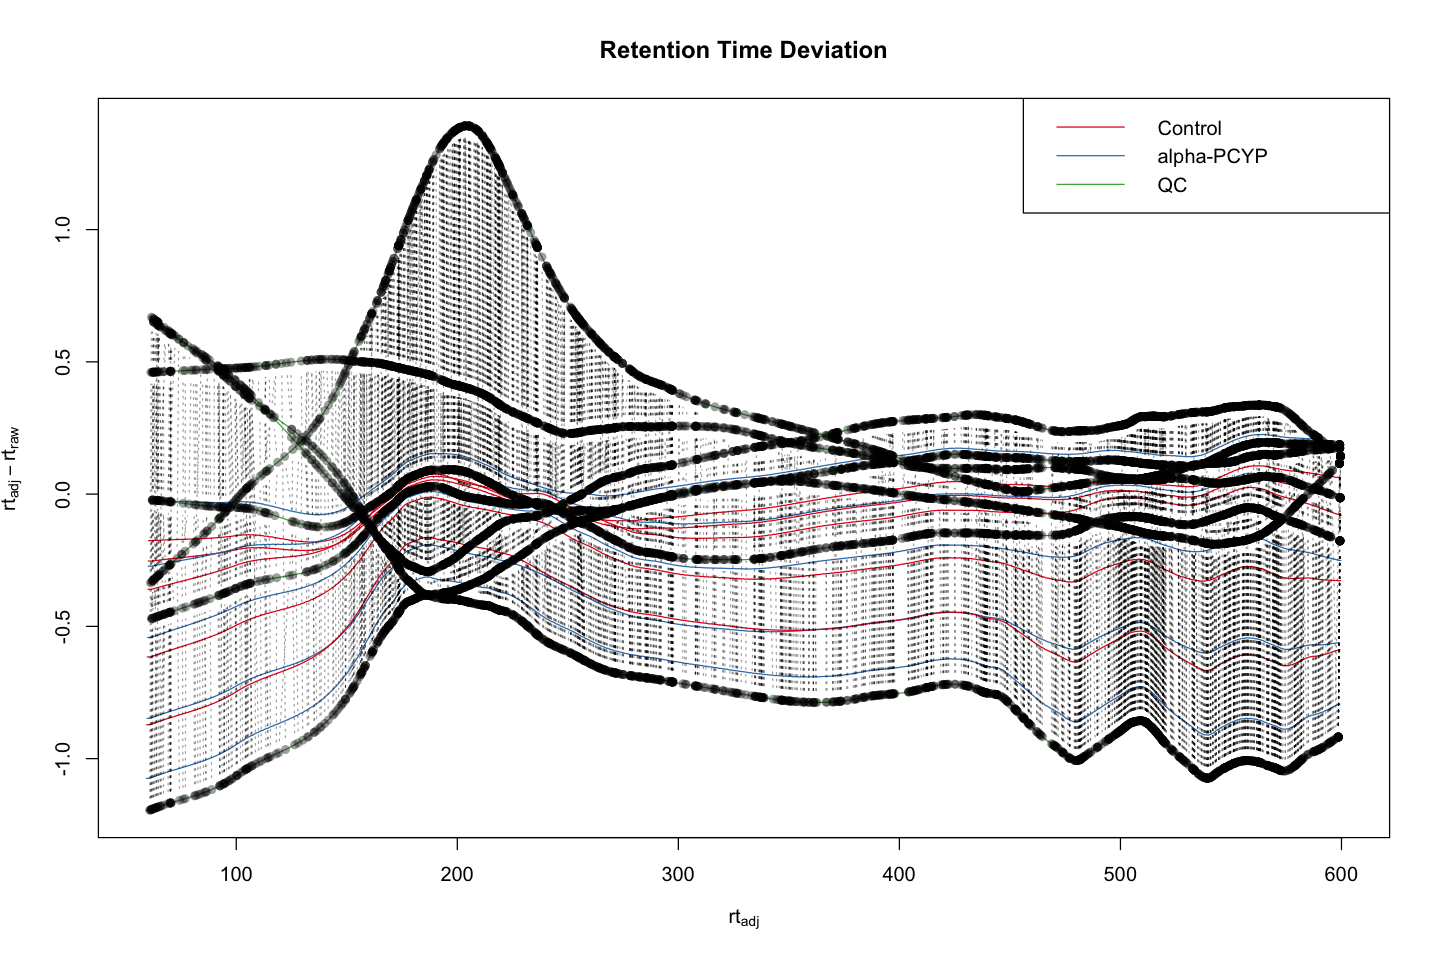

In [18]:
## Plot difference of adjusted to raw retention time.
plotAdjustedRtime(set, col = group.colours[set$sample_group], 
                  main = "Retention Time Deviation")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

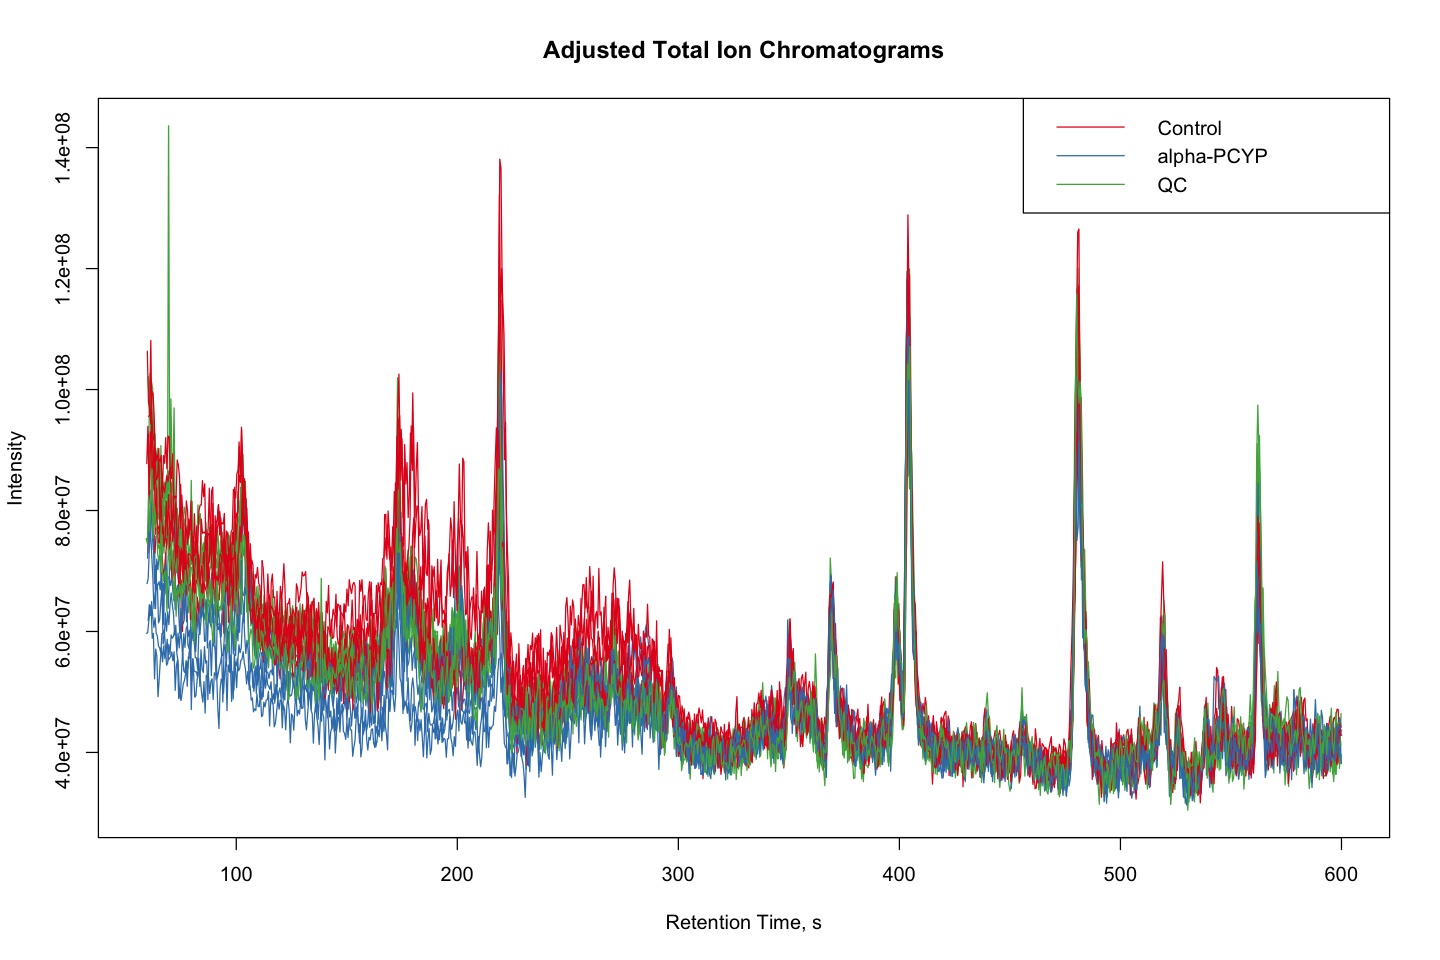

In [19]:
## Get the retention time-adjusted total ion chromatograms.
tics.corr <- chromatogram(set, aggregationFun = "sum")

plot(tics.corr, col = group.colours[tics.corr$sample_group], 
     peakType = "none", main = "Adjusted Total Ion Chromatograms", 
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), col = group.colours, lty = 1)

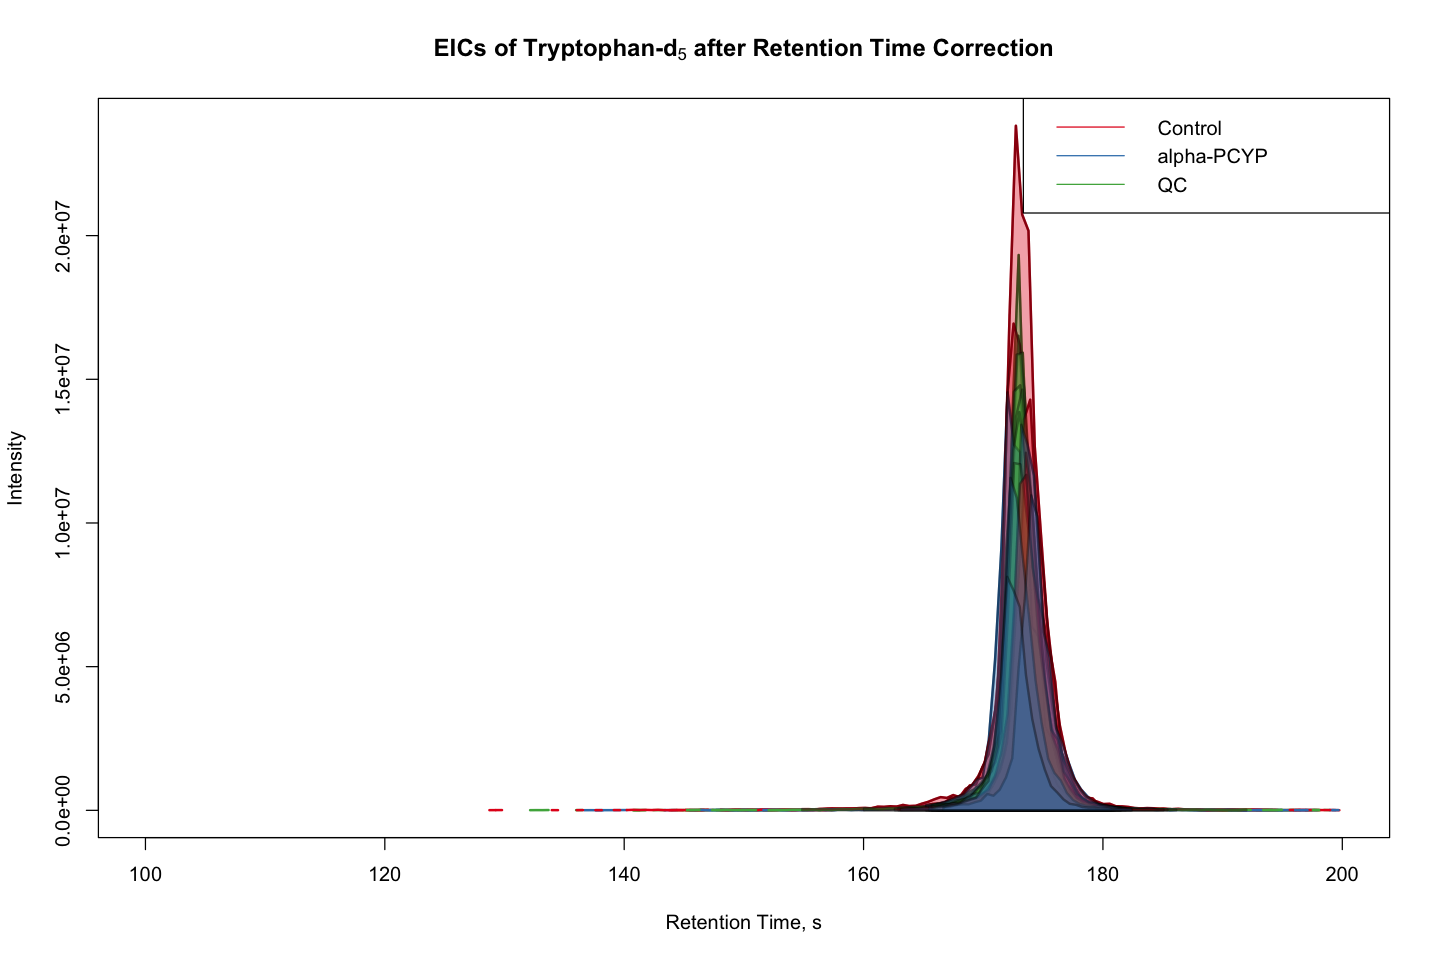

In [22]:
## Plot tryptophan-d5 after retention time correction (m/z 210.1291, 168 s)
trpd5.corr <- chromatogram(set, mz = c(210.1281, 210.1301), rt = c(100, 200))

plot(trpd5.corr, col = group.colours[trpd5.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(trpd5.corr)[, "sample"]],
     peakPch = 16, main = bquote(bold("EICs of Tryptophan-d"[5]*" after Retention Time Correction")),
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [23]:
## Plot Crea after after retention time correction (m/z 114.0665, 287 s)
crea.corr <- chromatogram(set, mz = c(114.0645, 114.0685), rt = c(100, 500))

plot(crea.corr, col = group.colours[crea.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(crea.corr)[, "sample"]],
     peakPch = 16, main = bquote(bold("EICs of Crea after Retention Time Correction")),
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

ERROR: Error in .plotChromatogramList(x[i, , drop = TRUE], col = col, lty = lty, : Objekt 'crea.raw' nicht gefunden


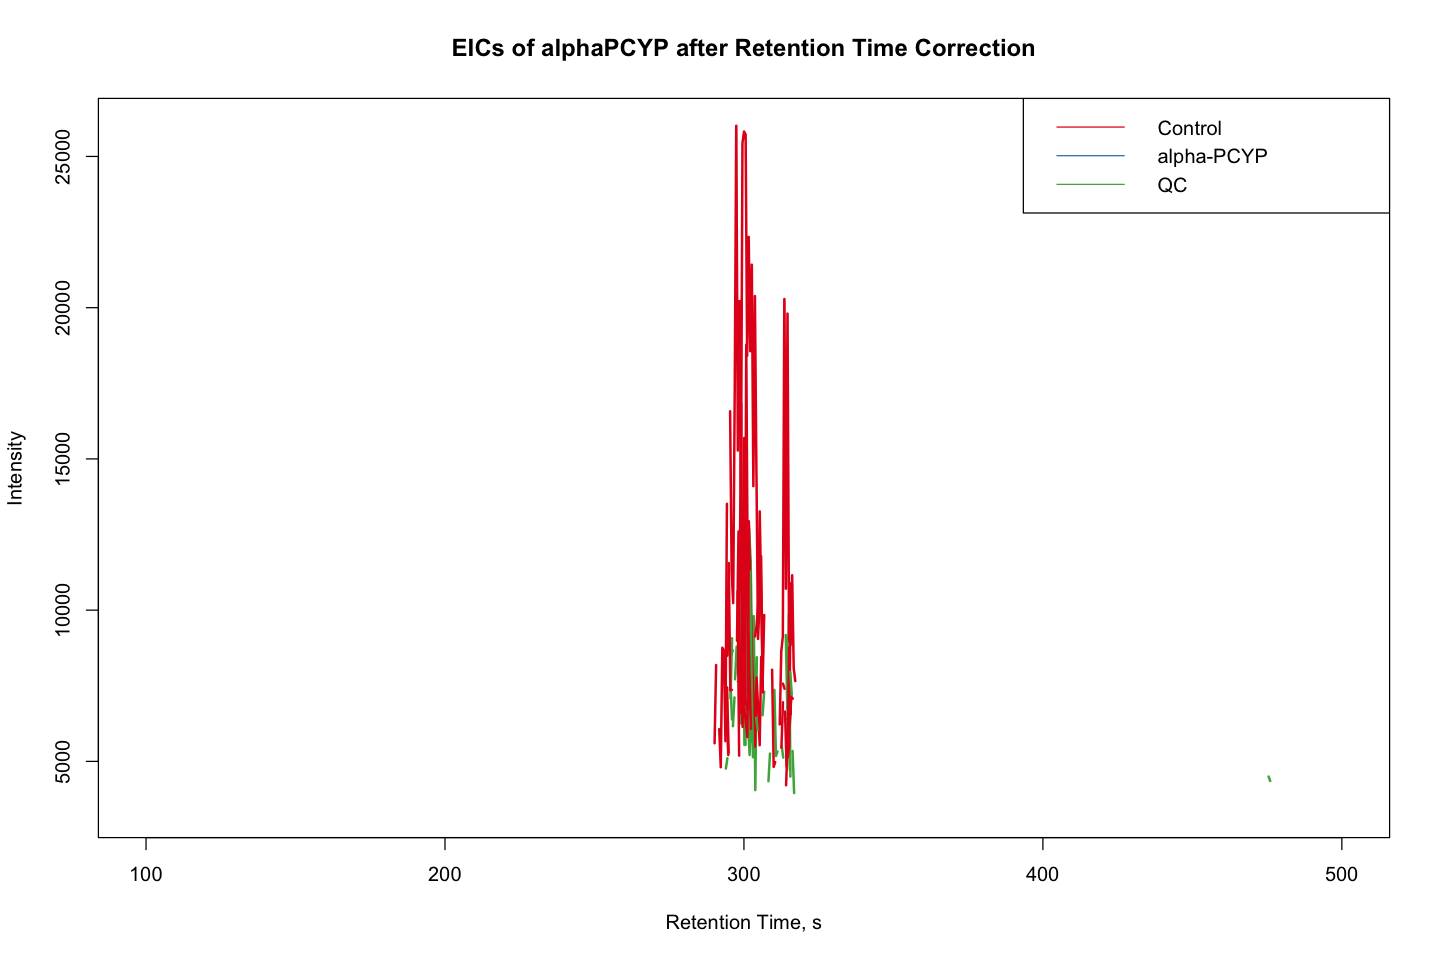

In [24]:
## Plot alpha-PCYP after retention time correction (m/z 272.2008, 314 s)
alphaPCYP.corr <- chromatogram(set, mz = c(272.2000, 272.2015), rt = c(100, 500))

plot(alphaPCYP.corr, col = group.colours[alphaPCYP.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(alphaPCYP.corr)[, "sample"]],
     peakPch = 16, main = bquote(bold("EICs of alphaPCYP"*" after Retention Time Correction")),
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Peak Grouping

In [25]:
suppressMessages(
    
    set <- groupChromPeaks(set, param = pdp)
    
)

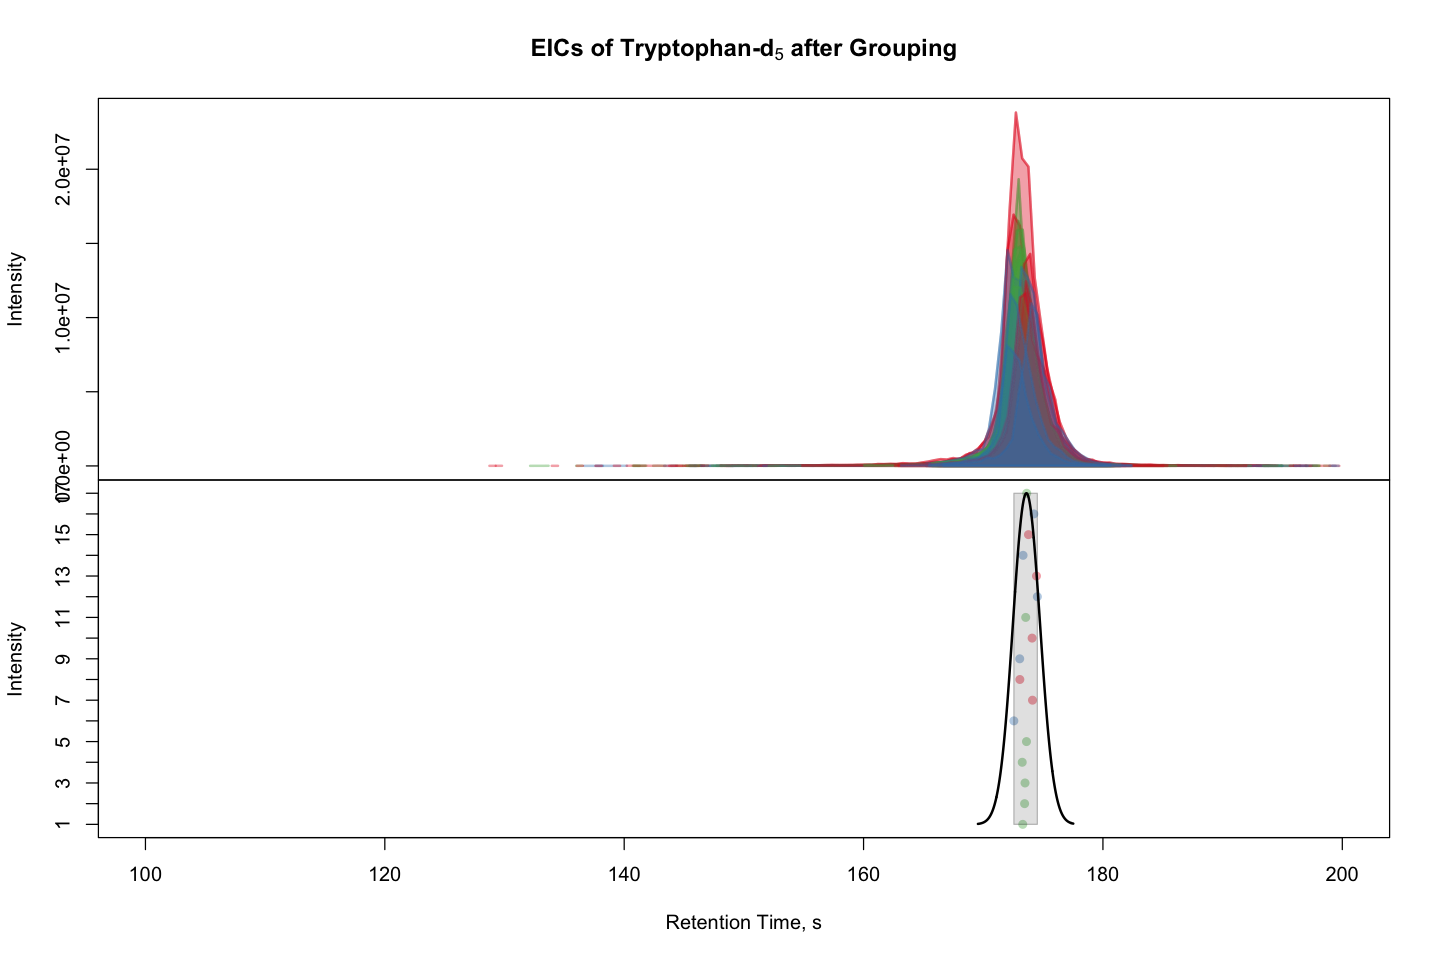

In [26]:
## Plot trp-d5 after peak grouping
trpd5.grouped <- chromatogram(set, mz = c(210.1281, 210.1301), rt = c(100, 200))

## Define the parameters for the peak density method
plotChromPeakDensity(trpd5.grouped, col = sample.colours, param = pdp, lwd = 2,
                     peakBg = sample.colours[chromPeaks(trpd5.grouped)[, "sample"]],
                     peakCol = sample.colours[chromPeaks(trpd5.grouped)[, "sample"]],
                     peakPch = 16, main = bquote(bold("EICs of Tryptophan-d"[5]*" after Grouping")),
                     xlab = "Retention Time, s", ylab = "Intensity")

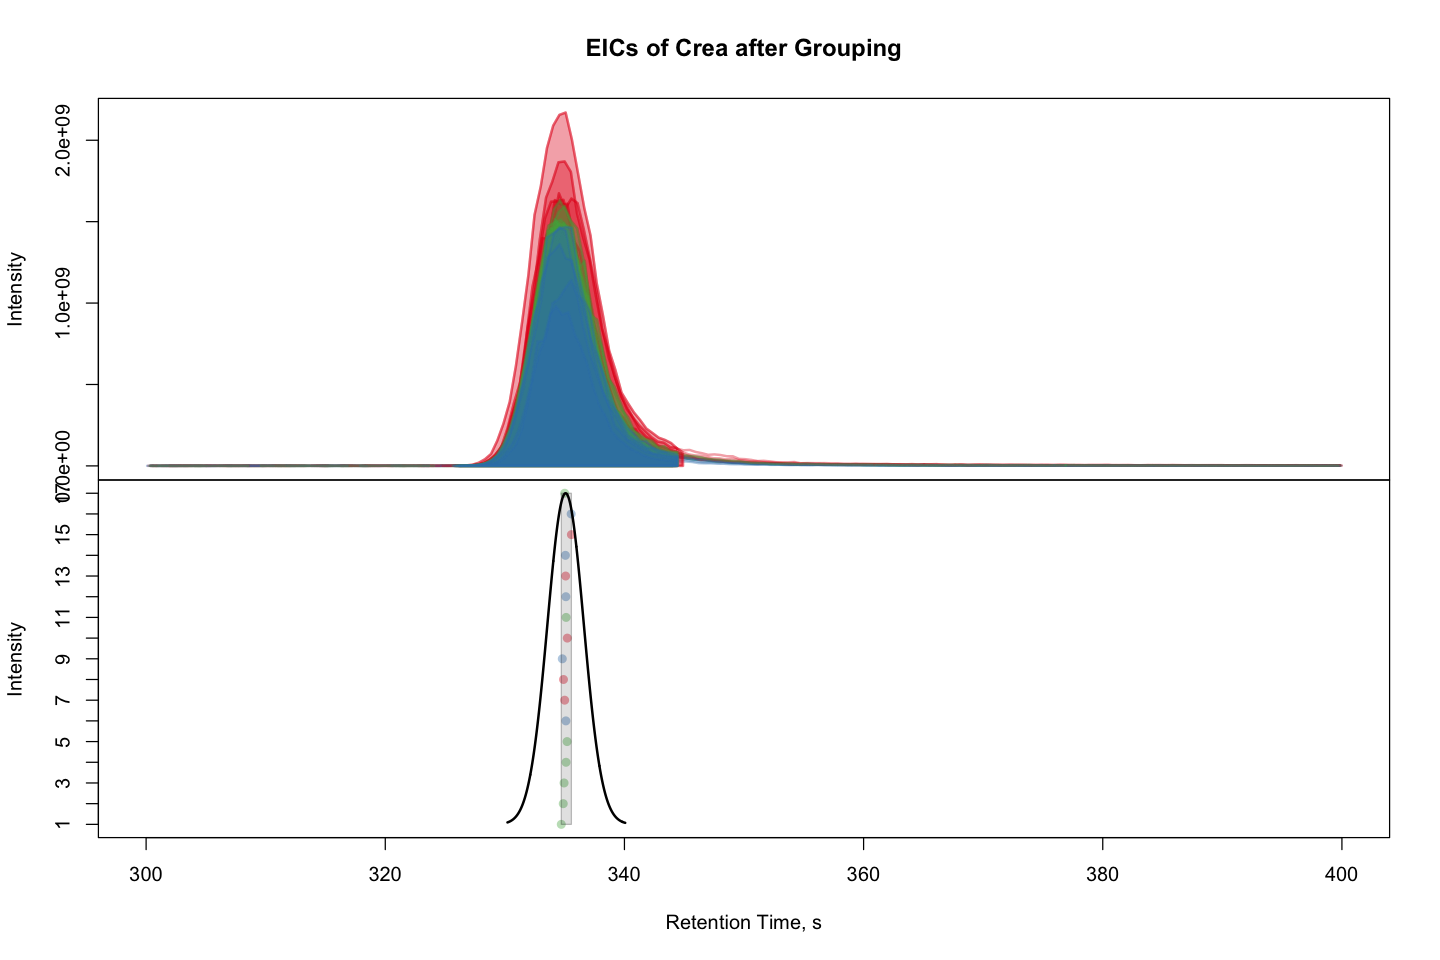

In [31]:
## Plot Crea after peak grouping
crea.grouped <- chromatogram(set, mz = c(114.0645, 114.0685), rt = c(300, 400))

## Define the parameters for the peak density method
plotChromPeakDensity(crea.grouped, col = sample.colours, param = pdp, lwd = 2,
                     peakBg = sample.colours[chromPeaks(crea.grouped)[, "sample"]],
                     peakCol = sample.colours[chromPeaks(crea.grouped)[, "sample"]],
                     peakPch = 16, main = bquote(bold("EICs of Crea after Grouping")),
                     xlab = "Retention Time, s", ylab = "Intensity")

# Peak Filling

In [27]:
suppressMessages(    
     
    set <- fillChromPeaks(set, param = ChromPeakAreaParam())
    
)

ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'param' bei der Methodenauswahl für Funktion 'fillChromPeaks': konnte Funktion "ChromPeakAreaParam" nicht finden


# Postprocessing


# Annotation of Adducts and Isotopes

In [28]:
## Summarise experiment
results <- quantify(set, value = "into")
class(results)

[1] "SummarizedExperiment"
attr(,"package")
[1] "SummarizedExperiment"

In [29]:
rowData(results) %>%
head()

DataFrame with 6 rows and 12 columns
           mzmed     mzmin     mzmax     rtmed     rtmin     rtmax    npeaks
       <numeric> <numeric> <numeric> <numeric> <numeric> <numeric> <numeric>
FT0001   59.0501   59.0501   59.0502  297.0689  296.4806  297.6724        17
FT0002   59.0501   59.0501   59.0502  285.5381  284.7674  286.0345        17
FT0003   62.0376   62.0376   62.0440   63.9798   62.9092   69.7942        31
FT0004   71.0496   71.0495   71.0496  481.8068  480.6209  482.2367        13
FT0005   73.5038   73.5000   73.5244  480.7362  480.1010  484.0398         9
FT0006   73.4855   73.4674   73.5065   70.6104   67.3155   73.2159        11
       alpha.PCYP   Control        QC               peakidx  ms_level
        <numeric> <numeric> <numeric>                <list> <integer>
FT0001          5         5         7     921,3227,5591,...         1
FT0002          5         5         7     920,3226,5590,...         1
FT0003          5         5         7     997,1378,3081,...        

In [30]:
## Add classic feature names
rowData(results)$label <- paste0("M",round(rowData(results)$mzmed,0),
                           "T", round(rowData(results)$rtmed,0))
rowData(results) %>%
head()

DataFrame with 6 rows and 13 columns
           mzmed     mzmin     mzmax     rtmed     rtmin     rtmax    npeaks
       <numeric> <numeric> <numeric> <numeric> <numeric> <numeric> <numeric>
FT0001   59.0501   59.0501   59.0502  297.0689  296.4806  297.6724        17
FT0002   59.0501   59.0501   59.0502  285.5381  284.7674  286.0345        17
FT0003   62.0376   62.0376   62.0440   63.9798   62.9092   69.7942        31
FT0004   71.0496   71.0495   71.0496  481.8068  480.6209  482.2367        13
FT0005   73.5038   73.5000   73.5244  480.7362  480.1010  484.0398         9
FT0006   73.4855   73.4674   73.5065   70.6104   67.3155   73.2159        11
       alpha.PCYP   Control        QC               peakidx  ms_level
        <numeric> <numeric> <numeric>                <list> <integer>
FT0001          5         5         7     921,3227,5591,...         1
FT0002          5         5         7     920,3226,5590,...         1
FT0003          5         5         7     997,1378,3081,...        

In [31]:
assay(results) %>% 
head()

pQC_1.mzXML pQC_2.mzXML pQC_3.mzXML pQC_4.mzXML pQC_5.mzXML
FT0001  971716.3    889706.94   919317.2    909871      869102.3  
FT0002 1105105.0   1011154.85  1116296.7   1119169     1128992.1  
FT0003 2908533.0   4326752.52  2799539.1   3498377     6834046.6  
FT0004  151491.2    173084.06   171020.5        NA      125447.3  
FT0005        NA           NA   152342.8        NA            NA  
FT0006  128089.4     70699.66    66021.8        NA            NA  
       24h_Urine_Rat_Control_5.mzXML 24h_Urine_Rat_PCYP_4.mzXML
FT0001  919313.76                     938010.6                 
FT0002 1129425.87                    1175080.2                 
FT0003 2105747.20                    7434222.0                 
FT0004  140866.01                           NA                 
FT0005         NA                           NA                 
FT0006   73959.84                           NA                 
       24h_Urine_Rat_PCYP_1.mzXML 24h_Urine_Rat_Control_3.mzXML
FT0001  996188.27                  931462.14                   
FT0002 1284718.00                 1222127.17                   
FT0003 4096436.36                 3973720.98                   
FT0004  103513.86                         NA                   
FT0005  141495.63                         NA                   
FT0006   71529.96                   59342.82                   
       24h_Urine_Rat_PCYP_2.mzXML pQC_6.mzXML 24h_Urine_Rat_Control_2.mzXML
FT0001  893318.5                   939768.5    951001.4                    
FT0002 1186070.7                  1039174.2   1226723.3                    
FT0003 3802607.1                  3582080.8   2817305.8                    
FT0004  148179.5                   147951.1    122132.2                    
FT0005        NA                         NA    100243.2                    
FT0006        NA                    73670.9          NA                    
       24h_Urine_Rat_PCYP_5.mzXML 24h_Urine_Rat_Control_4.mzXML
FT0001  938728.01                  957636.23                   
FT0002 1135119.05                 1144300.61                   
FT0003 2519751.58                 1861195.41                   
FT0004   98912.48                   96794.52                   
FT0005         NA                   76411.19                   
FT0006   86422.44                         NA                   
       24h_Urine_Rat_PCYP_3.mzXML 24h_Urine_Rat_Control_1.mzXML pQC_7.mzXML
FT0001  903912.04                  862180.48                     980860.9  
FT0002 1155806.91                 1230645.43                    1083584.9  
FT0003 3472624.35                 1922956.27                    3204255.0  
FT0004         NA                  111223.99                           NA  
FT0005   95718.93                  161085.46                           NA  
FT0006   78750.59                   66024.53                           NA

In [32]:
## Perform annotation using CAMERA
suppressMessages({
    
    camera <- set %>%
              as("xcmsSet") %>%
              CAMERA::annotate(polarity  = "positive") %>%
              getPeaklist() %>%
              dplyr::select(isotopes, adduct, pcgroup)
    
})

## Save annotation results in SummarizedExperiment class
rowData(results)$isotopes <- camera$isotopes
rowData(results)$adduct <- camera$adduct
rowData(results)$pcgroup <- camera$pcgroup

Start grouping after retention time.
Created 128 pseudospectra.
Generating peak matrix!
Run isotope peak annotation
 % finished: 10  20  30  40  50  60  70  80  90  100  
Found isotopes: 530 
Start grouping after correlation.
Generating EIC's .. 

Calculating peak correlations in 128 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  

Calculating graph cross linking in 128 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  
New number of ps-groups:  1372 
xsAnnotate has now 1372 groups, instead of 128 
Generating peak matrix for peak annotation!

Calculating possible adducts in 1372 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  


# Scaling

Before log10 transformation, every NA in the data matrix is replaced by the surrogate LOD according to Wehrens et al. at DOI: 10.1007/s11306-016-1015-8. The surrogate LOD is the lowest area that was measured during the analysis.

In [33]:
assays(results)

List of length 1
names(1): raw

In [34]:
# Replacing 0s with surrogate LOD
lod <- assay(results, "raw")[is.na(assay(results, "raw")) == FALSE] %>%
       min()
assay(results, "raw")[is.na(assay(results, "raw"))] <- lod

# Create assay results after log10 transformation
assay(results, "scaled") <- assay(results, "raw") %>%
                            log10()

In [35]:
assays(results)

List of length 2
names(2): raw scaled

In [36]:
results %>%
assay("scaled") %>%
head()

pQC_1.mzXML pQC_2.mzXML pQC_3.mzXML pQC_4.mzXML pQC_5.mzXML
FT0001 5.987539    5.949247    5.963465    5.958980    5.939071   
FT0002 6.043404    6.004818    6.047780    6.048896    6.052691   
FT0003 6.463674    6.636162    6.447087    6.543867    6.834678   
FT0004 5.180388    5.238257    5.233048    4.237773    5.098461   
FT0005 4.237773    4.237773    5.182822    4.237773    4.237773   
FT0006 5.107513    4.849417    4.819687    4.237773    4.237773   
       24h_Urine_Rat_Control_5.mzXML 24h_Urine_Rat_PCYP_4.mzXML
FT0001 5.963464                      5.972208                  
FT0002 6.052858                      6.070068                  
FT0003 6.323406                      6.871236                  
FT0004 5.148806                      4.237773                  
FT0005 4.237773                      4.237773                  
FT0006 4.868996                      4.237773                  
       24h_Urine_Rat_PCYP_1.mzXML 24h_Urine_Rat_Control_3.mzXML
FT0001 5.998341                   5.969165                     
FT0002 6.108808                   6.087116                     
FT0003 6.612406                   6.599197                     
FT0004 5.014998                   4.237773                     
FT0005 5.150743                   4.237773                     
FT0006 4.854488                   4.773368                     
       24h_Urine_Rat_PCYP_2.mzXML pQC_6.mzXML 24h_Urine_Rat_Control_2.mzXML
FT0001 5.951006                   5.973021    5.978181                     
FT0002 6.074111                   6.016688    6.088747                     
FT0003 6.580081                   6.554135    6.449834                     
FT0004 5.170788                   5.170118    5.086830                     
FT0005 4.237773                   4.237773    5.001055                     
FT0006 4.237773                   4.867296    4.237773                     
       24h_Urine_Rat_PCYP_5.mzXML 24h_Urine_Rat_Control_4.mzXML
FT0001 5.972540                   5.981201                     
FT0002 6.055041                   6.058540                     
FT0003 6.401358                   6.269792                     
FT0004 4.995251                   4.985851                     
FT0005 4.237773                   4.883157                     
FT0006 4.936627                   4.237773                     
       24h_Urine_Rat_PCYP_3.mzXML 24h_Urine_Rat_Control_1.mzXML pQC_7.mzXML
FT0001 5.956126                   5.935598                      5.991607   
FT0002 6.062885                   6.090133                      6.034863   
FT0003 6.540658                   6.283969                      6.505727   
FT0004 4.237773                   5.046198                      4.237773   
FT0005 4.980998                   5.207056                      4.237773   
FT0006 4.896254                   4.819705                      4.237773

# Normalisation

In [50]:
## Define function to calculate ppm deviation
ppm <- function(x,y) {

    return(10^6 * (x - y) / y)

}

## Define function to identify row of compound
identify <- function(data, mz, rt, ppmlim, rtlim) {

    delta.mz <- abs(mapply(ppm, x = data$mzmed, y = mz))
    delta.rt <- abs(data$rtmed - rt)
    return(which(delta.mz < ppmlim & delta.rt < rtlim))
    
}

In [51]:
## Identify rownumber of internal standard tryptophan-d5
crea <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 114.0666, rt = 335, 5, 10)

In [53]:
## Normalise data to internal standard
norm.is <- function(x, is){x/x[is]}
assay(results, "norm") <- apply(assay(results, "scaled"),2, norm.is, is = crea)

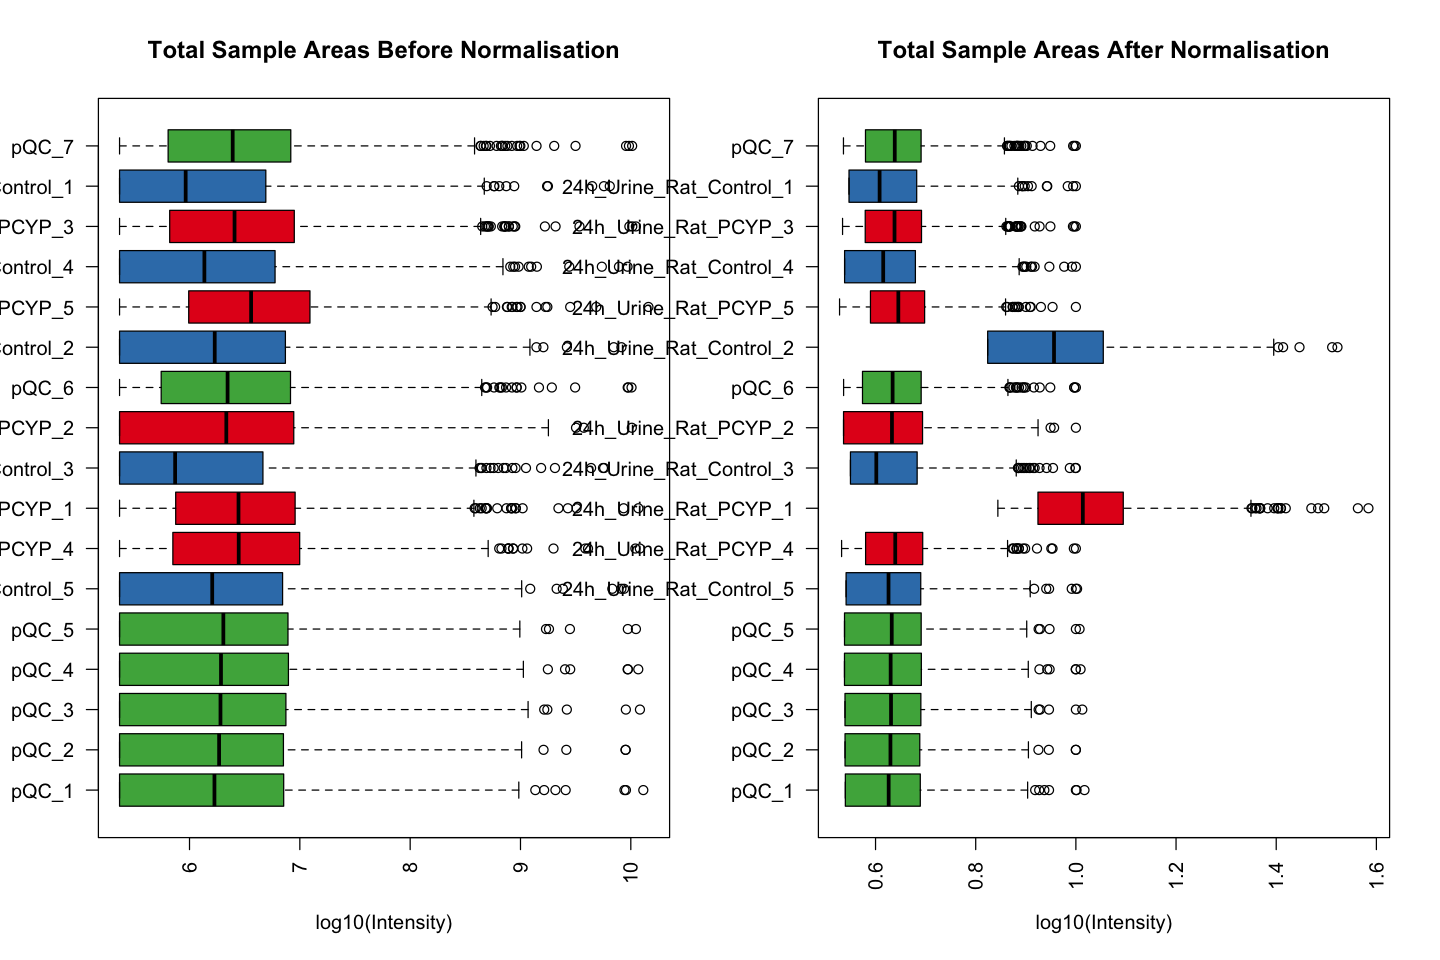

In [54]:
## Compare normalised and unnormalised data
par(mfrow = c(1,2))

results %>%
assay("scaled") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Normalisation", las = 2)

results %>%
assay("norm") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Normalisation", las = 2)

# Batch correction

In [37]:
## Define function to perform batch correction
batchCorrection <-function(area, order, group, output = c("df", "corr")) {
        
    df <- data.frame(order = order, area = area)
    model <- lm(area ~ order, data = df[group == "QC",])
    df$pred <- predict(model, newdata = df)
    df$corr <- df$corr <- df$area - df$pred + mean (df$area)
    return(switch(output, df = df, corr = df$corr))
    
}

In [38]:
## Filter features by detectability in QC samples
#results.filtered <- results[rowData(results)$QC == 9,]

In [39]:
## Perform batch correction
assay(results, "batchcorr",
      withDimnames = FALSE) <- apply(assay(results, "scaled"), 
                                     1, batchCorrection, 
                                     order = set$sample_order, 
                                     group = set$sample_group, 
                                     output = "corr") %>%
                                     t()

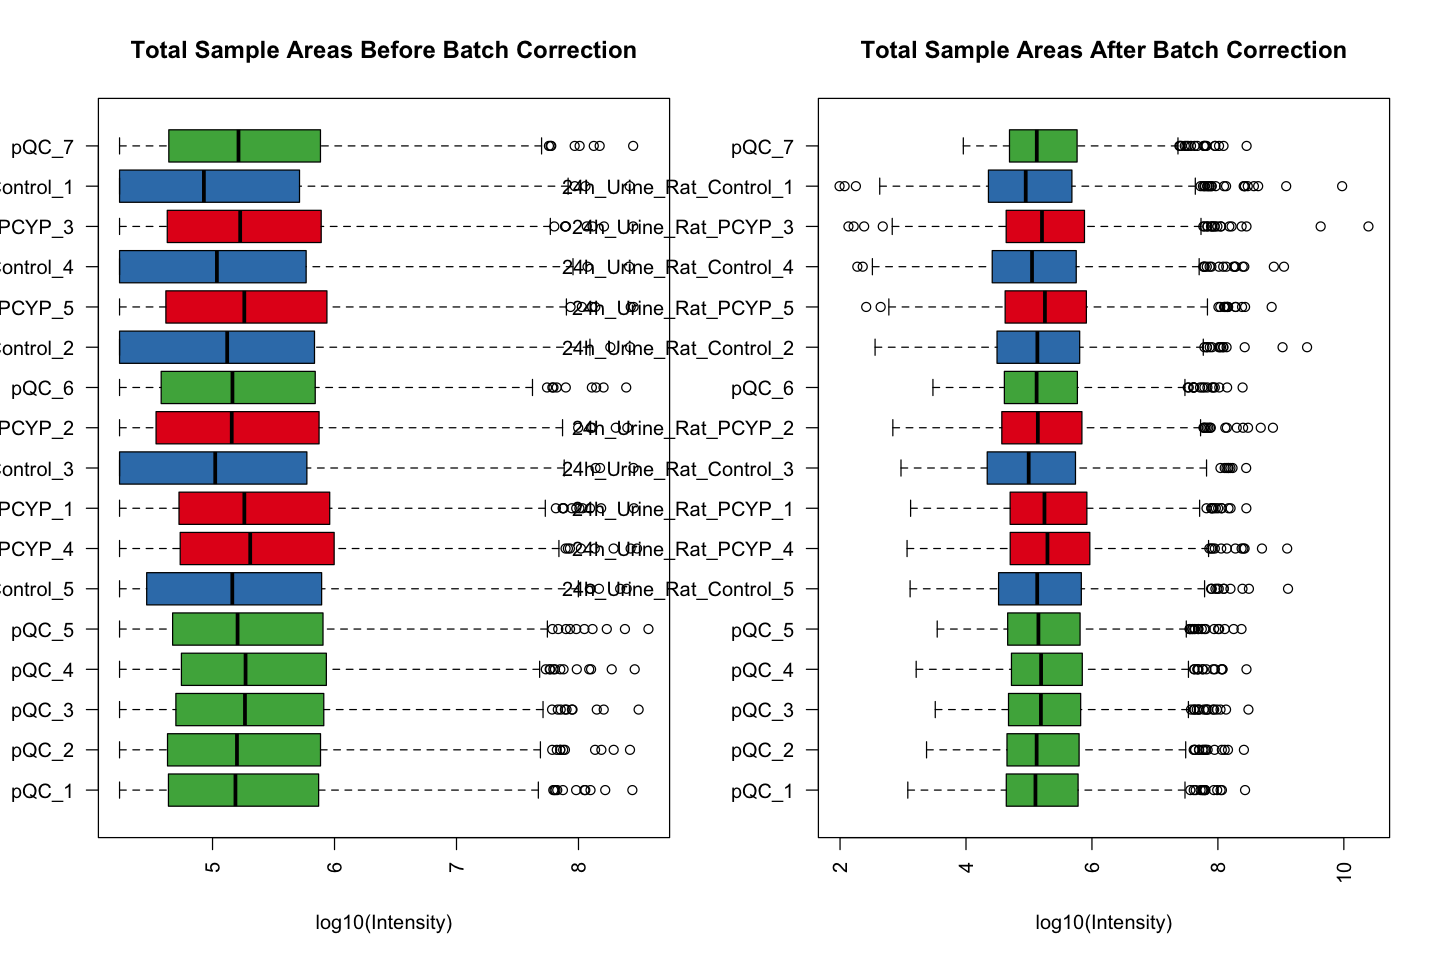

In [40]:
## Compare batch-corrected and uncorrected total sample areas
par(mfrow = c(1,2))

results %>%
assay("scaled") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Batch Correction", las = 2)

results %>%
assay("batchcorr") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Batch Correction", las = 2)

In [41]:
## Compare batch-corrected and uncorrected areas of compounds
df <- batchCorrection(assay(results, "scaled")[51,], 
                      set$sample_order, set$sample_group, "df")

## Perform regression using corrected values
lm <- lm(area ~ order, data = df[results$sample_group == "QC",])
lm.new <- lm(corr ~ order, data = df[results$sample_group == "QC",])

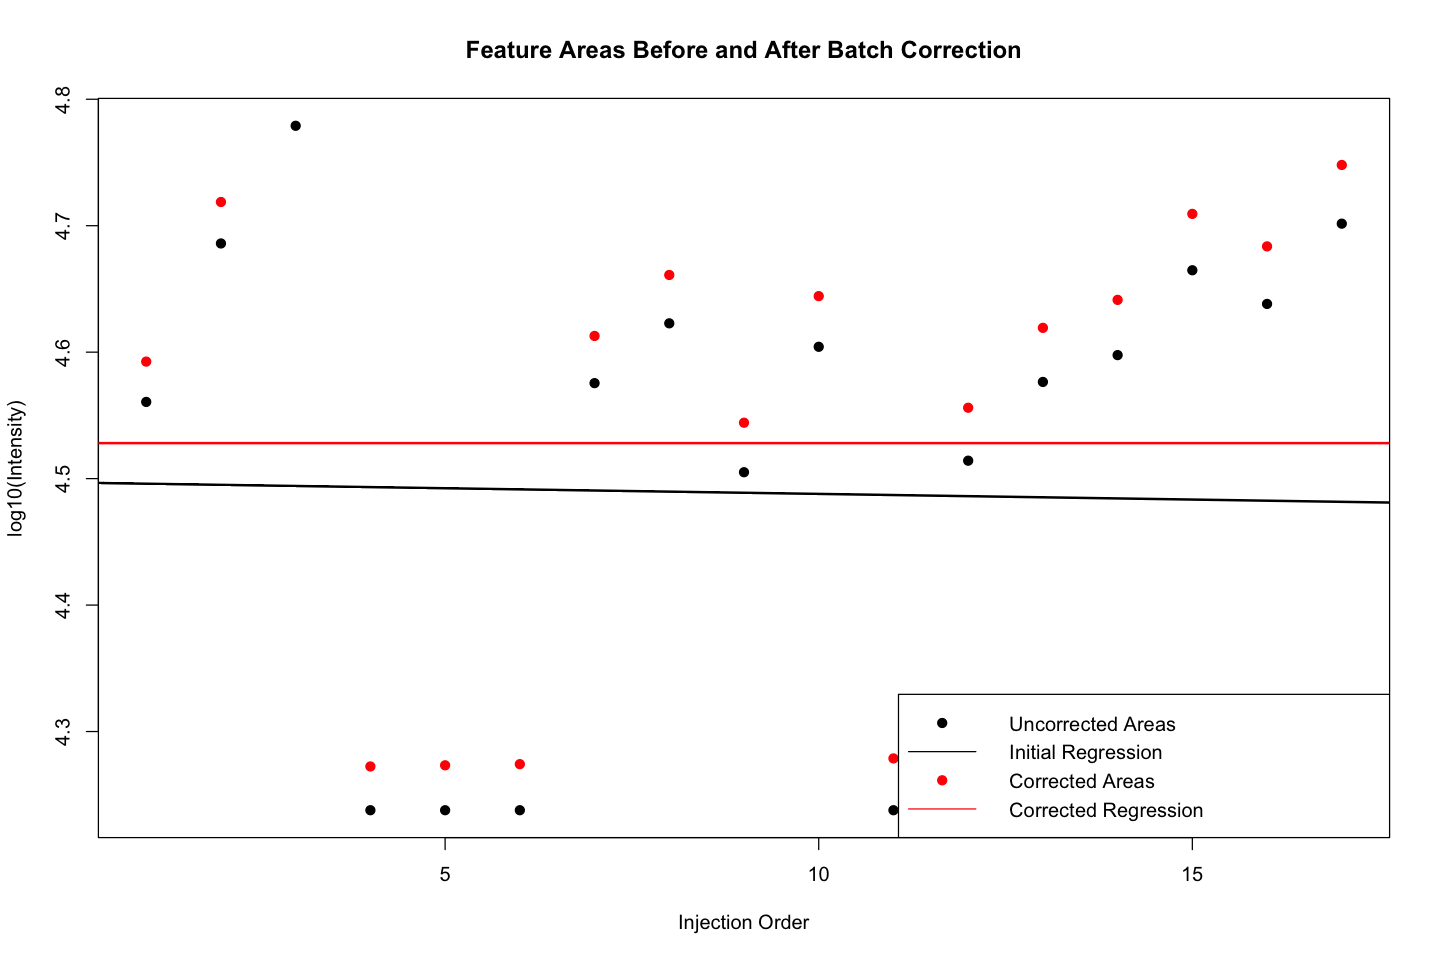

In [42]:
## Plot uncorrected and corrected models and data points
plot(df$order, df$area, col = "black", pch = 19,
     xlab = "Injection Order", ylab = "log10(Intensity)", 
     main = "Feature Areas Before and After Batch Correction")
abline(lm, lwd = 2, col = "black")
points(df$order, df$corr, col = "red", pch = 19)
abline(lm.new, lwd = 2, col = "red")
legend("bottomright", lty = c(NA,1,NA,1), pch=c(19,NA,19,NA),
       legend = c("Uncorrected Areas", "Initial Regression", 
                  "Corrected Areas", "Corrected Regression"), 
       col = c("black", "black", "red", "red"))